# Contrastive Language-Image Pre-Training (CLIP)

# Introduction

CLIP (Contrastive Language-Image Pre-training) is a neural neural network developed by OpenAI in 2021 lead by Alec Radford. It represents a significant advancement in the field of computer vision by bridge the gap between visual and textual understanding. The model efficiently learns visual concepts from natural language supervision. Instead of being trained on a specific task like image classification (i.e. ResNet, Inception, VGG and MobileNet) or object detection (i.e. YOLO), CLIP is trained on a massive dataset of text and image pairs. This allows it to understand the relationship between images and their textual description. 

**How it works:**

- **Contrastive Learning:** CLIP is trained to predict which caption from a batch corresponds to the input image. It learns to **maximize** the similarity between the image and its correct caption while **minimizing** the similarity with incorrect captions. This **contrastive** approach allows the model to learn rich representations of both images and texts.
- **Large-Scale Dataset**: CLIP is trained on a dataset of 400 million image-text pairs scraped from the internet. This massive dataset provides a diverse range of visual concepts and their corresponding textual descriptions, enabling CLIP to generalize well to various downstream tasks.
- **Transformer Architecture**: CLIP utilizes a Transformer architecture for both image and text encoding. The image encoder processes the image into a vector representation, while the text encoder processes the text caption into another vector representation. The model learns to align these vectors for matching image-text pairs.

**Key Features and Capabilities:**

- **Zero-Shot Learning:** One of CLIP's most significant capabilities is zero-shot learning. This means it can perform tasks it hasn't explicitly been trained on. For example, it can classify images into categories it has never seen before, simply by providing a textual description of the category.
- **Robustness and Generalization:** Due to its diverse training data, CLIP is more robust and generalizes better to unseen images and tasks compared to traditional image recognition models.
- **Flexibility:** CLIP can be used for various tasks beyond image classification, including image retrieval, object detection, and image captioning.
- **Interpretability:** While deep learning models are often considered black boxes, CLIP offers some level of interpretability. By examining the text embeddings, one can gain insights into the features the model uses for classification.

Limitations:
- **Bias:** Like any model trained on internet data, CLIP can inherit biases present in the data. This can lead to unfair or inaccurate predictions for certain groups or concepts.
- **Complex Prompts:** While CLIP excels at understanding simple prompts, it can struggle with more complex or nuanced language.
- **Fine-Grained Recognition:** CLIP may struggle with tasks requiring very fine-grained distinctions between visually similar objects.

**Applications:**
- **Image Search**: CLIP can be used to search for images based on textual descriptions.
- **Image Classification:** CLIP can classify images into various categories without requiring task-specific training data.
- **Object Detection:** CLIP can be adapted for object detection tasks.
- **Image Generation:** CLIP is often used in conjunction with generative models like DALL-E 2 and Stable Diffusion to guide the generation of images from text prompts.
- **Content Moderation:** CLIP can be used to identify potentially harmful or inappropriate content in images.


**References**:

- [Paper](https://arxiv.org/pdf/2103.00020.pdf)
- [Official OpenAI repo](https://github.com/openai/CLIP)
- [HuggingFace implementation](https://huggingface.co/sentence-transformers/clip-ViT-L-14)
- [X-CLIP repo](https://github.com/lucidrains/x-clip)


# Vision Embeddings

The primary job of the vision embedding module is to take an input image and transform it into a fixed-size vector representation, also known as an **embedding**. This embedding captures the key visual features present in the image. The key here is to create an embedding that's semantically meaningful – that is, images that are visually similar and/or semantically related should have embeddings that are close to each other in the embedding space (i.e. similar edges, textures, shapes).

**Patch Extraction/Tokenization + Linear Projection (CNN layer)**:
- The input image is divided into a grid of small, non-overlapping patches (e.g., 14x14 pixels).
- Each of these patches is then flattened into a vector. Think of it as converting each tiny image square into a linear representation.
- The result is a sequence of vectors, where each vector represents one of the image's patches. This is similar to how a sentence is broken into words. We treat each patch-vector like a "word" in the language of the image.
- Each patch vector undergoes a linear transformation via a matrix multiplication. This means each patch vector is multiplied by a learnable matrix to produce a lower-dimensional representation. 
- This process aims to map the patch vectors into a more manageable and semantically relevant space for subsequent processing. The linear projection step is a learned step.

**Positional Encoding**:
- Positional information is added to each of the projected patch vectors. This step is crucial because, by themselves, the patch vectors have no information on where they came from in the original image.
- The positional encoding is a small vector added to each patch representation that encodes the patch's position within the original image, making sure that the model can understand spatial relationships between patches in the image.
- After this step, each patch vector contains information about the patch's visual content and its location in the image.

In [1]:
from torch import nn
from transformers.models.clip.configuration_clip import CLIPVisionConfig, CLIPTextConfig, CLIPConfig 
from transformers.models.clip.modeling_clip import CLIPTextTransformer, CLIPVisionTransformer, CLIPOutput
from typing import Callable, Union, cast
import torch as t
import einops
from matplotlib import pyplot as plt
from dataclasses import dataclass
from torch.nn import functional as F

In [2]:
class CLIPVisionEmbeddings(nn.Module):
    config: CLIPVisionConfig
    patch_size: int
    image_size: int
    embed_dim: int
    num_patches: int
    class_embedding: nn.Parameter
    patch_embedding: nn.Conv2d
    position_embedding: nn.Embedding
    position_ids: t.Tensor

    def __init__(self, config: CLIPVisionConfig):
        """Assign values from input config to class member variables as appropriate."""
        super().__init__()
        self.config = config
        self.patch_size = config.patch_size 
        self.image_size = config.image_size
        self.embed_dim = config.hidden_size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches

        self.class_embedding = nn.Parameter(t.randn(self.embed_dim)) 
        self.patch_embedding = nn.Conv2d(
            in_channels=3,
            out_channels=self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            bias=False,
        )
        self.position_embedding = nn.Embedding(self.num_positions + 1, self.embed_dim)
        self.register_buffer("position_ids", t.arange(self.num_positions + 1).expand((1, -1)), persistent=False) 

    def forward(self, x: t.Tensor) -> t.Tensor:
        """
        Apply the patch embeddings and the positional embeddings and return their sum.

        x: shape (batch, channels=3, height=224, width=224)
        out: shape (batch, sequence, hidden)
        """
        B, C, H, W = x.shape

        # Apply patch embeddings
        patch_embed = self.patch_embedding(x)
        patch_embed = einops.rearrange(patch_embed, "batch hidden grid_h grid_w -> batch (grid_h grid_w) hidden")

        # Apply positional embeddings
        pos_embed = self.position_embedding(self.position_ids) # Get absolute positional embeddings
        class_embedding = einops.repeat(self.class_embedding, "hidden -> batch 1 hidden", batch=B, hidden=self.embed_dim)

        # Combine class and positional embeddings with patch embeddings
        return t.cat((class_embedding, patch_embed), dim=1) + pos_embed

## CLIP MLP


The MLP in CLIP operates on embedding vectors of `hidden_size` dimension, making it independent of whether the input was text or images. 
It follows the standard transformer MLP architecture:
1. A Linear layer that expands from `hidden_size` to `intermediate_size` (4x larger)
2. A GELU activation function using a sigmoid approximation for faster computation
3. A Linear layer that projects back down to `hidden_size`

The GELU approximation used here is from the original [GELU](https://arxiv.org/pdf/1606.08415.pdf) paper, which uses a sigmoid function to approximate the exact GELU. This approximation is faster while maintaining similar behavior.


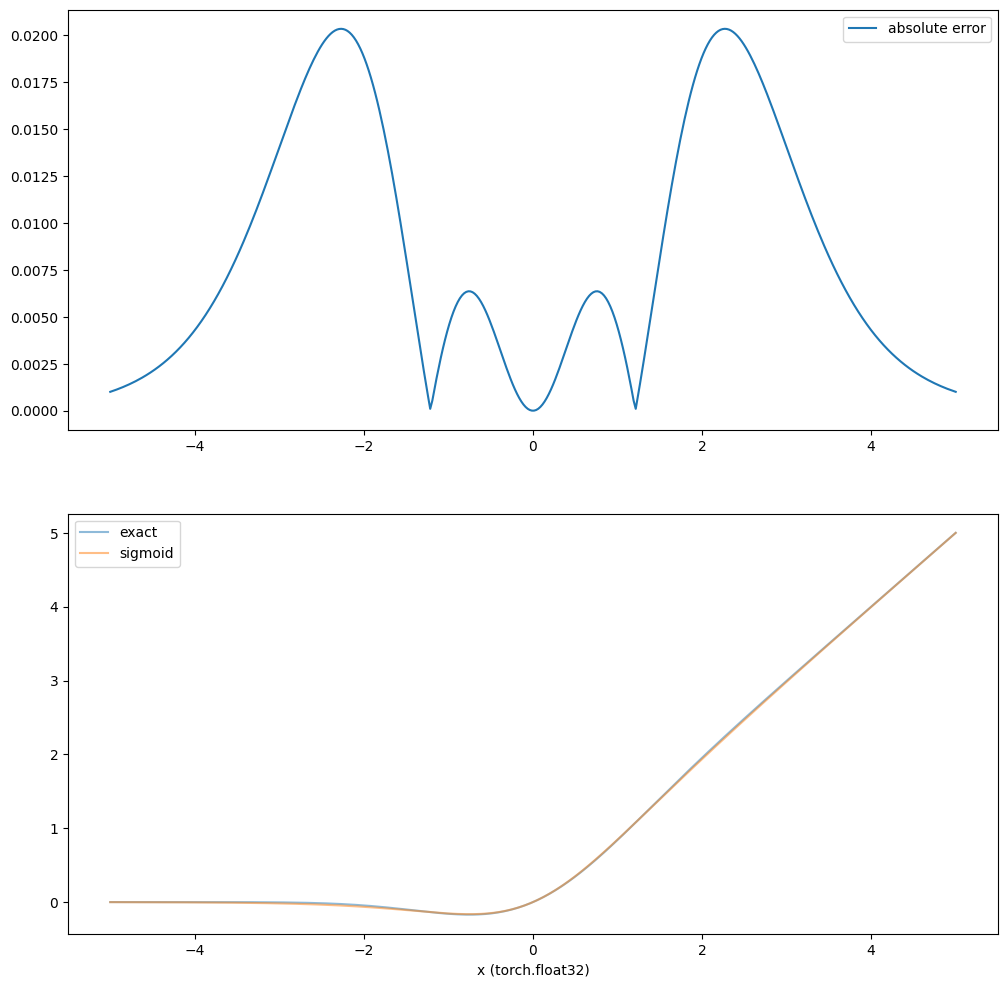

In [3]:
def gelu_sigmoid_approximation(x: t.Tensor) -> t.Tensor:
    """Return sigmoid approximation of GELU of input tensor x with same shape."""
    return x * t.sigmoid(1.702 * x)


def plot_gelu_approximation(x: t.Tensor):
    fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(12, 12))  # type: ignore
    actual = F.gelu(x)
    approx = gelu_sigmoid_approximation(x)
    diff = (actual - approx).abs()
    x_cpu = x.cpu()
    ax0.plot(x_cpu, diff.cpu(), label="absolute error")
    ax0.legend()
    ax1.plot(x_cpu, actual.cpu(), label="exact", alpha=0.5)
    ax1.plot(x_cpu, approx.cpu(), label="sigmoid", alpha=0.5)
    ax1.legend()
    ax1.set(xlabel=f"x ({x.dtype})")

x = t.linspace(-5, 5, 400)
plot_gelu_approximation(x)

class CLIPMLP(nn.Module):
    fc1: nn.Linear
    fc2: nn.Linear

    def __init__(self, config: Union[CLIPVisionConfig, CLIPTextConfig]):
        """Initialize parent class, then assign fully-connected layers based
        on shape in input config"""
        super().__init__()
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, x: t.Tensor) -> t.Tensor:
        """Run forward pass of MLP, including fully-connected layers and non-linear
        activations where appropriate"""
        x = self.fc1(x)
        x = gelu_sigmoid_approximation(x)
        x = self.fc2(x)
        return x


## Self-Attention

Self-attention in CLIP works very similarly to GPT, with a few key differences:

1. Unlike GPT which uses masked attention (each token can only attend to previous tokens), 
   CLIP uses full/bidirectional attention where each token can attend to all other tokens.
   This makes sense since we want each image patch to be able to look at the full context.
2. The attention mechanism still uses `Query (Q), Key (K), and Value (V) projections`:
   - Input embeddings are projected into `Q, K, V` using separate linear layers
   - `Q` and `K` are multiplied to get attention scores (how much each token should attend to others)
   - Scores are scaled by `1/sqrt(head_size)` and softmaxed to get attention weights
   - Weights are used to compute weighted sum of `V` to get the output

3. Multi-head attention is used just like in GPT:
   - The hidden states are split into multiple heads
   - Each head can learn different attention patterns
   - The outputs from all heads are concatenated and projected back to hidden_size


In [4]:
class CLIPAttention(nn.Module):
    num_heads: int
    head_size: int
    q_proj: nn.Linear
    k_proj: nn.Linear
    v_proj: nn.Linear
    out_proj: nn.Linear
    dropout: nn.Dropout

    def __init__(self, config: Union[CLIPVisionConfig, CLIPTextConfig]):
        """Assign values from input config to class member variables as appropriate"""
        super().__init__()
        self.num_heads = config.num_attention_heads
        assert config.hidden_size % config.num_attention_heads == 0
        self.head_size = config.hidden_size // config.num_attention_heads
        self.q_proj = nn.Linear(config.hidden_size, config.num_attention_heads * self.head_size)
        self.k_proj = nn.Linear(config.hidden_size, config.num_attention_heads * self.head_size)
        self.v_proj = nn.Linear(config.hidden_size, config.num_attention_heads * self.head_size)
        self.out_proj = nn.Linear(config.num_attention_heads * self.head_size, config.hidden_size)
        self.dropout = nn.Dropout(config.dropout)

    def attention_pattern_pre_softmax(self, x: t.Tensor) -> t.Tensor:
        """Return the attention pattern after scaling but before softmax (QK circuit).

        pattern[batch, head, q, k] should be the match between a query at sequence position q and a key at sequence position k.
        """
        B, S, H = x.shape
        Q = self.q_proj(x)
        Q = rearrange(Q, "b seq (head head_size) -> b head seq head_size", head=self.num_heads)
        K = self.k_proj(x)
        K = rearrange(K, "b seq (head head_size) -> b head seq head_size", head=self.num_heads)
        out = einsum("b head seq_q head_size, b head seq_k head_size -> b head seq_q seq_k", Q, K)
        out = out / (self.head_size**0.5)
        assert out.shape == (B, self.num_heads, S, S)
        return out

    def forward(self, x: t.Tensor) -> t.Tensor:
        """Perform forward pass through attention layer, computing attention pattern and value projections
        to combine into output after applying dropout."""
        B, S, H = x.shape

        # Combine QK and OV circuits
        attention_pattern = self.attention_pattern_pre_softmax(x)
        softmaxed_attention = attention_pattern.softmax(dim=-1)
        V = self.v_proj(x)
        V = rearrange(V, "b seq (head head_size) -> b head seq head_size", head=self.num_heads)
        combined_values = einsum(
            "b head seq_k head_size, b head seq_q seq_k -> b head seq_q head_size",
            V,
            softmaxed_attention,
        )

        # Multi-head attention
        out = self.out_proj(rearrange(combined_values, "b head seq head_size -> b seq (head head_size)"))
        out = self.dropout(out)
        assert out.shape == (B, S, H)
        return out


## CLIP Encoder Layer

The CLIP encoder layer is almost identical to the GPT encoder layer, with a few key differences:
1. The attention mechanism is the same as in CLIP, but the MLP is slightly different (using the sigmoid approximation).
2. The layer normalization is applied to the input before the attention and MLP.


In [5]:
class CLIPEncoder(nn.Module):
    def __init__(self, config: Union[CLIPVisionConfig, CLIPTextConfig]):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = CLIPAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim)
        self.mlp = CLIPMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim)

    def forward(self, x):
        x = x + self.self_attn(self.layer_norm1(x))
        x = x + self.mlp(self.layer_norm2(x))
        return x

## CLIP Vision Transformer

In [6]:
class CLIPVisionTransformer(nn.Module):
    config: CLIPVisionConfig
    embeddings: CLIPVisionEmbeddings
    pre_layrnorm: nn.LayerNorm
    encoder: CLIPEncoder
    post_layernorm: nn.LayerNorm

    def __init__(self, config: CLIPVisionConfig):
        """Assign values from input config to class member variables as appropriate"""
        "SOLUTION"
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size
        self.embeddings = CLIPVisionEmbeddings(config)
        self.pre_layrnorm = nn.LayerNorm(embed_dim)
        self.encoder = CLIPEncoder(config)
        self.post_layernorm = nn.LayerNorm(embed_dim)

    def forward(self, x: t.Tensor) -> t.Tensor:
        """Perform forward pass through vision transformer: embedding, layer norm, encoder, layer norm
        Return output corresponding to prepended class_embedding"""
        "SOLUTION"
        x = self.embeddings(x)
        x = self.pre_layrnorm(x)
        x = self.encoder(x)
        x = x[:, 0]
        x = self.post_layernorm(x)
        return x

## CLIP Model

In [7]:
class CLIPModel(nn.Module):
    config: CLIPConfig
    text_config: CLIPTextConfig
    vision_config: CLIPVisionConfig
    projection_dim: int
    text_embed_dim: int
    vision_embed_dim: int
    text_model: CLIPTextTransformer
    vision_model: CLIPVisionTransformer
    visual_projection: nn.Linear
    text_projection: nn.Linear
    logit_scale: nn.Parameter

    def __init__(self, config: CLIPConfig):
        """Assign values from input config to class member variables as appropriate.
        """
        super().__init__()
        self.config = config
        text_config = config.text_config
        vision_config = config.vision_config

        self.projection_dim = config.projection_dim
        self.text_embed_dim = text_config.hidden_size
        self.vision_embed_dim = vision_config.hidden_size

        self.text_model = CLIPTextTransformer(text_config)  
        self.vision_model = CLIPVisionTransformer(vision_config)

        self.visual_projection = nn.Linear(self.vision_embed_dim, self.projection_dim, bias=False)
        self.text_projection = nn.Linear(self.text_embed_dim, self.projection_dim, bias=False)
        self.logit_scale = nn.Parameter(t.ones([]) * self.config.logit_scale_init_value)  

    def forward(self, input_ids: t.Tensor, attention_mask: t.Tensor, pixel_values: t.Tensor) -> CLIPOutput:
        """
        Perform forward pass through CLIP model, applying text and vision model/projection.

        input_ids: (batch, sequence)
        attention_mask: (batch, sequence). 1 for visible, 0 for invisible.
        pixel_values: (batch, channels, height, width)
        """
        vis = self.vision_model(pixel_values)
        vis = self.visual_projection(vis)
        vis = vis / vis.norm(p=2, dim=-1, keepdim=True)
        text = self.text_model(input_ids, attention_mask).pooler_output
        text = self.text_projection(text)
        text = text / text.norm(p=2, dim=-1, keepdim=True)
        return CLIPOutput(text, vis)

In [8]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

print("\nCLIP Results:")
print("-" * 50)
print("Input image: Cat photo from COCO dataset")
print("Text prompts: ['a photo of a cat', 'a photo of a dog']")
print("\nProbabilities:")
for i, text in enumerate(["cat", "dog"]):
    print(f"{text}: {probs[0][i].item():.2%}")
print("-" * 50)
print("CLIP correctly identifies the image as a cat with high confidence!")


CLIP Results:
--------------------------------------------------
Input image: Cat photo from COCO dataset
Text prompts: ['a photo of a cat', 'a photo of a dog']

Probabilities:
cat: 99.92%
dog: 0.08%
--------------------------------------------------
CLIP correctly identifies the image as a cat with high confidence!


## Contrastive Loss

Contrastive loss works by making corresponding image-text pairs more similar to each other while making non-corresponding pairs less similar.

For example, if we have:
- Text1: "a dog playing fetch"
- Text2: "a cat sleeping" 
- Image1: [photo of dog playing fetch]
- Image2: [photo of cat sleeping]

| Text/Image | Image1 | Image2 |
|-----------|--------|--------|
| Text1     | HIGH   | low    |
| Text2     | low    | HIGH   |


The loss pushes the model to:
1. Give HIGH similarity scores on the diagonal (matching pairs)
2. Give low similarity scores everywhere else (non-matching pairs)

This teaches the model to embed related images and text close together in the embedding space,
while pushing unrelated pairs far apart. It's like teaching the model to play a matching game -
each text description should match most strongly with its corresponding image.

The cross_entropy loss compares against the ground truth indices - for each text/image, the highest similarity should be with index i=i (the diagonal).

We average the loss in both directions (text->image and image->text) to ensure the embeddings work well for both retrieval directions.




In [9]:
def contrastive_loss(text_embeds: t.Tensor, image_embeds: t.Tensor, logit_scale: t.Tensor) -> t.Tensor:
    """Return the contrastive loss between a batch of text and image embeddings.

    The embeddings must be in order so that text_embeds[i] corresponds with image_embeds[i].

    text_embeds: (batch, output_dim)
    image_embeds: (batch, output_dim)
    logit_scale: () - log of the scale factor to apply to each element of the similarity matrix

    Out: scalar tensor containing the loss
    """
    assert text_embeds.shape == image_embeds.shape
    similarity = t.matmul(text_embeds, image_embeds.t()) * logit_scale.exp()
    caption_loss = F.cross_entropy(similarity.T, t.arange(len(similarity.T)))
    image_loss = F.cross_entropy(similarity, t.arange(len(similarity)))
    return (caption_loss + image_loss) / 2.0